<a href="https://colab.research.google.com/github/Santosh-Gupta/Lit2Vec/blob/master/2Book2VecPublicPlayGround2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
from collections import Counter
import time

%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from matplotlib import pyplot
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

from urllib.request import urlretrieve
import requests
from os.path import isfile, isdir
import zipfile

!pip install adjustText
from adjustText import adjust_text

In [0]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

In [0]:
file_id = '1fe5WTpjAaoKivd2XA1hvU0TmVXTkwGK3'

download_file_from_google_drive(file_id, 'model.zip')

file_id = '1w3uSNtc1srNaWoRHwbUE9o3baokloh9U'

download_file_from_google_drive(file_id, 'books.csv')

In [0]:
# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

b = pd.read_csv( 'books.csv' )
b.head(30)
bookDictionary = b.set_index('book_id').to_dict()['title']
bookDictionary[5]
AuthorDictionary = b.set_index('book_id').to_dict()['authors']

Uncompressing zip file


In [0]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./MODEL/bookVec.ckpt.meta')
  saver.restore(sess, './MODEL/bookVec.ckpt' )

  embeddings = tf.get_default_graph().get_tensor_by_name('embeddings:0') #Getting regular embeddings
  softmax_weights = tf.get_default_graph().get_tensor_by_name('softmax_weights:0') #Get softmax embeddings
  
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  normalized_embeddingsSM = softmax_weights / normSM
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()

In [0]:
#Use this code to get the book_id for any book using the authur name, using their full name, first name, or last name.  
#The search is case sensitive,  capitalize the first letter of any name. 

authorPhrase = 'Tolle'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], AuthorDictionary[j], ' | Book ID: ', j  )

A New Earth: Awakening to Your Life's Purpose Eckhart Tolle  | Book ID:  719
The Power of Now: A Guide to Spiritual Enlightenment Eckhart Tolle  | Book ID:  744
Practicing the Power of Now: Essential Teachings, Meditations, and Exercises from the Power of Now Eckhart Tolle  | Book ID:  2694


In [0]:
#Use this code to get the book_id for any book using the title, or a word in the title. 
#The search is case sensitive. All words in a title tend to be capitalized. 

searchPhrase = 'The Notebook'
lines = []
for i in bookDictionary:
  if type(bookDictionary[i]) is str:
    if searchPhrase in bookDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], AuthorDictionary[j], ' | Book ID: ', j  )

The Notebook (The Notebook, #1) Nicholas Sparks  | Book ID:  44
The Wedding (The Notebook, #2) Nicholas Sparks  | Book ID:  686


In [0]:
#James and the Giant Peach Roald Dahl, Quentin Blake  | Book ID:  335

JaneA = np.take(final_embeddings, 335, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

print('Most similiar to ', bookDictionary[nearestJaneA[0]], 'by',  AuthorDictionary[nearestJaneA[0]], '\n')

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Most similiar to  James and the Giant Peach by Roald Dahl, Quentin Blake 

James and the Giant Peach Roald Dahl, Quentin Blake
The Witches Roald Dahl, Quentin Blake
The BFG Roald Dahl, Quentin Blake
Charlie and the Chocolate Factory (Charlie Bucket, #1) Roald Dahl, Quentin Blake
Matilda Roald Dahl, Quentin Blake
The Twits Roald Dahl, Quentin Blake
Where the Wild Things Are Maurice Sendak
Danny the Champion of the World Roald Dahl, Quentin Blake
Fantastic Mr. Fox Roald Dahl, Quentin Blake
Charlie and the Great Glass Elevator (Charlie Bucket, #2) Roald Dahl, Quentin Blake
George's Marvellous Medicine Roald Dahl, Quentin Blake
Charlotte's Web E.B. White, Garth Williams, Rosemary Wells
The Lorax Dr. Seuss
The Cat in the Hat Dr. Seuss
The Very Hungry Caterpillar Board Book Eric Carle


In [0]:
hereGoesSM =  np.take(final_embeddings, 97, axis=0) -  np.take(final_embeddings, 205, axis=0)  

#dacula vampire classic vampire 97 - interview with vampire 205  = classics 

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]


for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Little Dorrit Charles Dickens, Helen Small, Stephen Wall
A Christmas Carol, The Chimes and The Cricket on the Hearth Charles Dickens, Katharine Kroeber Wiley
The Strange Case of Dr. Jekyll and Mr. Hyde and Other Tales of Terror Robert Louis Stevenson, Robert Mighall
The Picture of Dorian Gray: A Graphic Novel Ian Edginton, Oscar Wilde, I.N.J. Culbard
Our Mutual Friend Charles Dickens
The Moonstone Wilkie Collins, Carolyn G. Heilbrun
The Tenant of Wildfell Hall Anne Brontë, Stevie Davies
King Solomon's Mines (Allan Quatermain, #1) H. Rider Haggard
Eugene Onegin Alexander Pushkin, James E. Falen
The House of Silk (Sherlock Holmes, #1) Anthony Horowitz


In [0]:
# hereGoesSM =  np.take(final_embeddings, 97, axis=0) -  np.take(final_embeddings, 205, axis=0)  

# #dacula vampire classic vampire 97 - interview with vampire 205  = classics 

# similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

# nearesthereGoes = (-similarityhereGoes).argsort()[0:10]

In [0]:
NumberOfBooks = 200

extracted_v = np.take(final_embeddings, 110, axis=0)   
dotprods_v = np.matmul(extracted_v, np.transpose(final_embeddings))

nearestBooks = (-dotprods_v).argsort()[0:NumberOfBooks]

for_TSNE = np.take(final_embeddings, nearestBooks, axis=0) 

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(for_TSNE)

print(for_TSNE)
print(tsne)

books = [bookDictionary[i] for i in nearestBooks]
plot(two_d_embeddings, books)

[[ 0.04788313 -0.03870176  0.00857036 ...  0.07586104 -0.03972982
  -0.02362717]
 [ 0.10096589 -0.05130888 -0.0438726  ... -0.02733971 -0.01774261
  -0.02044436]
 [ 0.05913709  0.07000167 -0.09945778 ...  0.01526607 -0.03205759
  -0.06766701]
 ...
 [-0.03473762  0.0578254   0.04605758 ...  0.00342316 -0.03450672
   0.03552554]
 [ 0.05061148 -0.00689918 -0.01086968 ... -0.0157434  -0.01018224
   0.03920482]
 [ 0.1054612   0.08157901 -0.00869785 ... -0.02726369  0.03637777
  -0.01495848]]
TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
     method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
     n_iter=5000, n_iter_without_progress=300, perplexity=30, random_state=None,
     verbose=0)


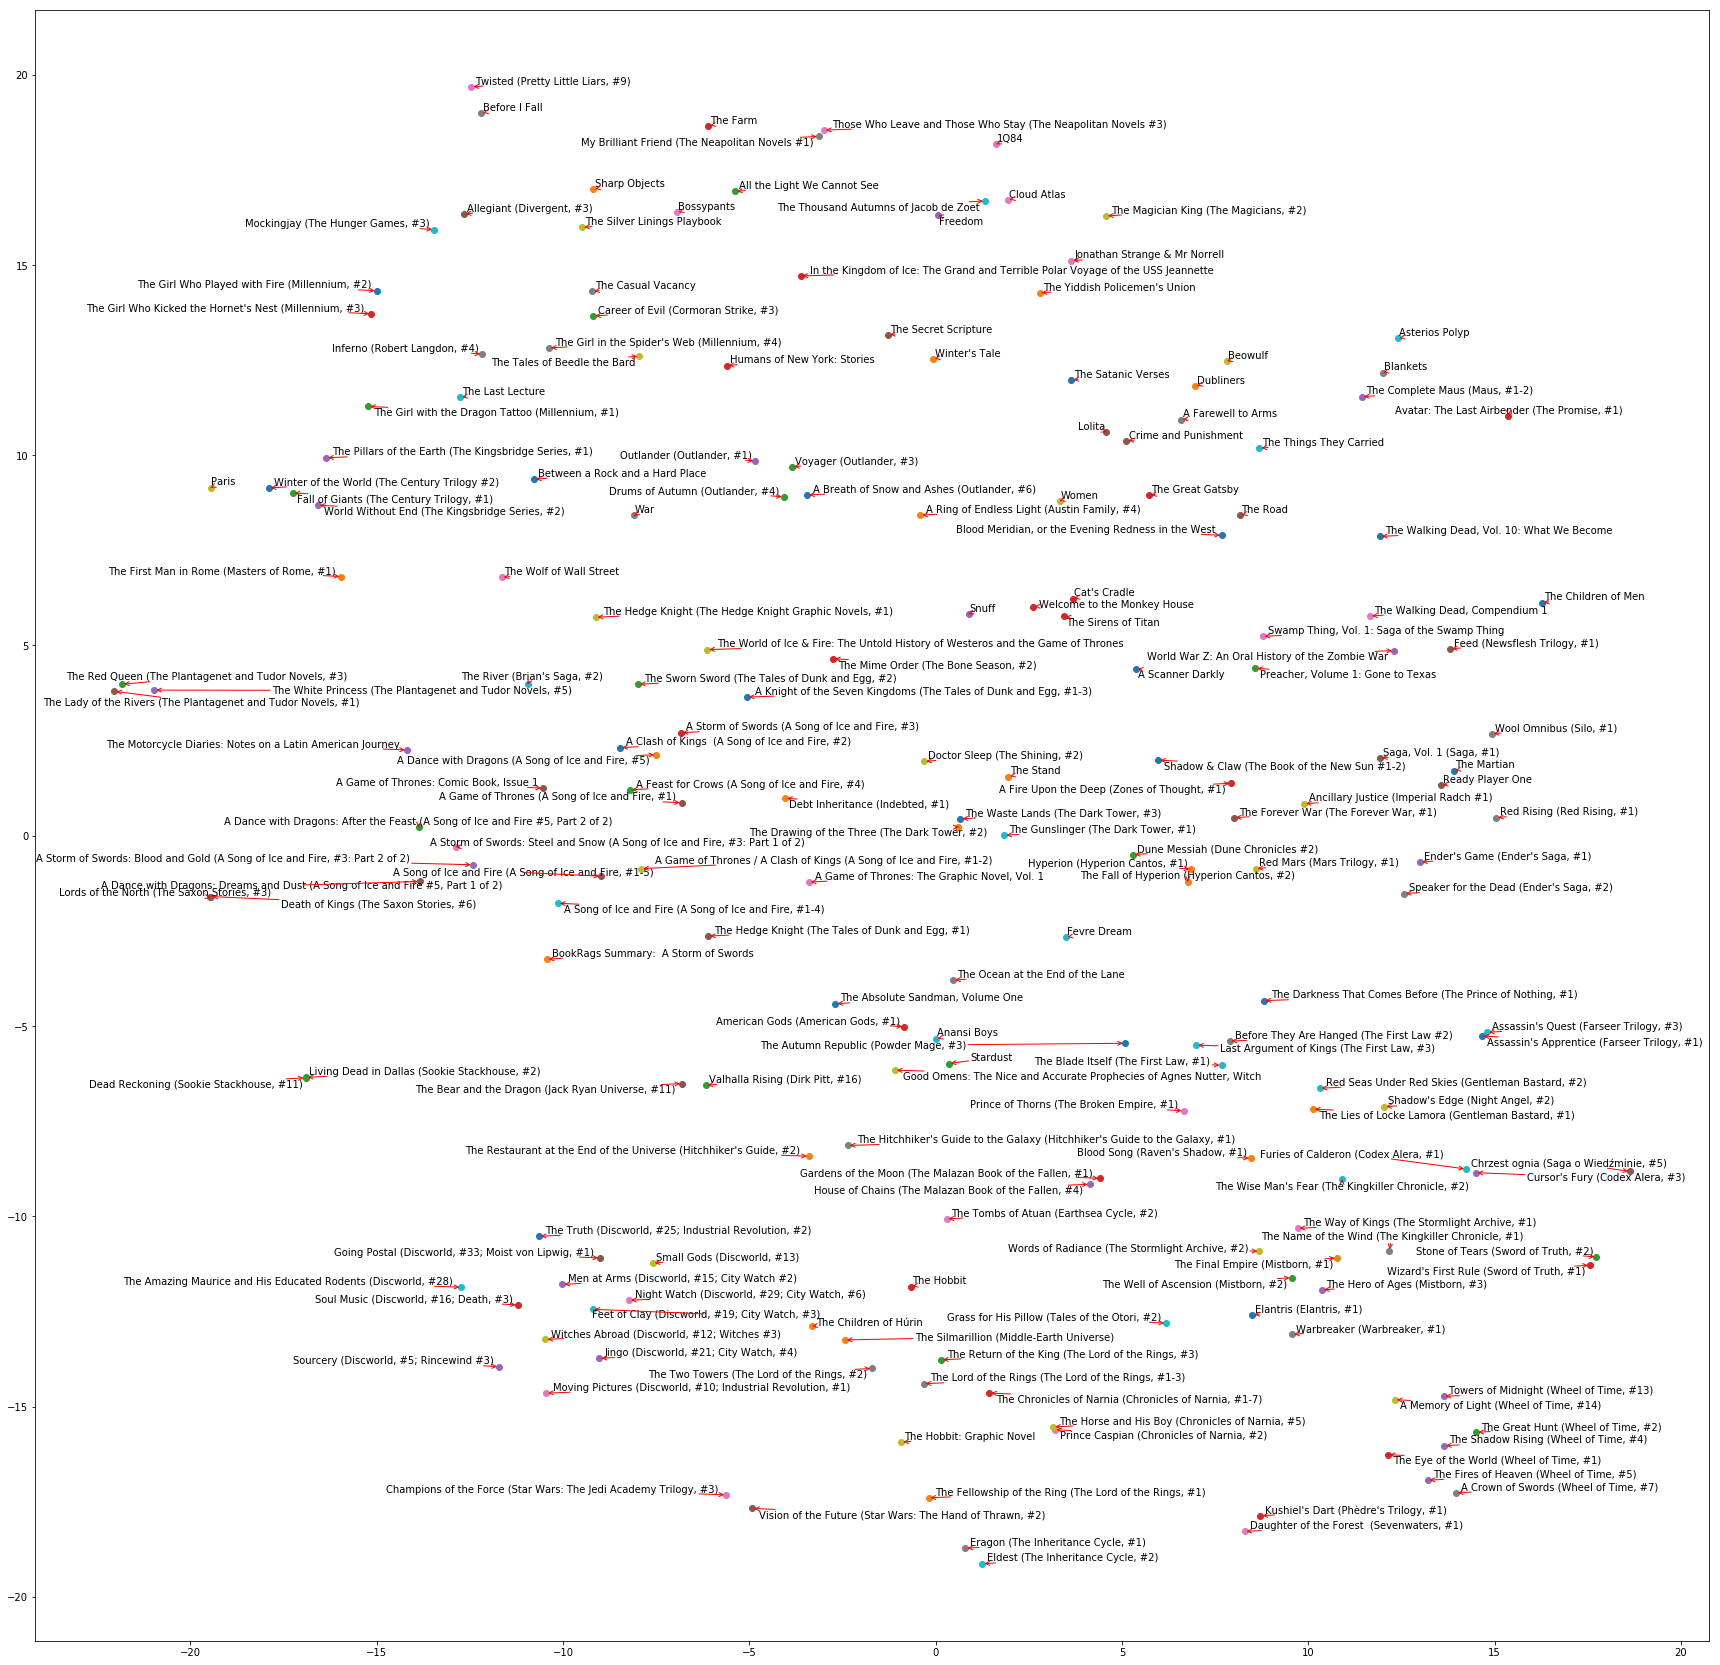

In [0]:
#Plot book embeddings 

texts = []

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pyplot.figure(figsize=(30, 30))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pyplot.scatter(x, y)
        #pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       #ha='right', va='bottom')
        texts.append(pyplot.text(x, y, label)) #Creates better plots but takes a long time. To save time, comment this, and uncomment the pyplot.annotate line
    adjust_text(texts , arrowprops=dict(arrowstyle='->', color='red'))
    pyplot.show()

plot(two_d_embeddings, books)